# Analysis of Cell Technology
3 competing cell technologies may claim marketshare in future; Bifacial PERC, bifacial SHJ, and Bifacial TOPCon. Each design has different efficiency and a different silver intensity. This analysis seeks compare these technologies on a mass and energy basis. A psuedo global deployment projection hitting 100% RE targets in 2050 is used so that silver demand can be evaluated at the global level.

Make 4+ scenarios
1. All PERC
2. All SHJ
3. All TOPCon
4. Realistic blend / ITRPV numbers from Martin Springer or Jarett Zuboy – DURAMat tech scounting report
5. All of the above and turn Bifacial ON/OFF

We will use the silver intensity and module efficiency projections from:

    Zhang, Yuchao, Moonyong Kim, Li Wang, Pierre Verlinden, and Brett Hallam. 2021. “Design Considerations for Multi-Terawatt Scale Manufacturing of Existing and Future Photovoltaic Technologies: Challenges and Opportunities Related to Silver, Indium and Bismuth Consumption.” Energy & Environmental Science. https://doi.org/10.1039/D1EE01814K. 

and

    Gervais, Estelle, Shivenes Shammugam, Lorenz Friedrich, and Thomas Schlegl. 2021. “Raw Material Needs for the Large-Scale Deployment of Photovoltaics – Effects of Innovation-Driven Roadmaps on Material Constraints until 2050.” Renewable and Sustainable Energy Reviews 137 (March): 110589. https://doi.org/10.1016/j.rser.2020.110589.

In [1]:
import numpy as np
import pandas as pd
import os,sys
from pathlib import Path
import matplotlib.pyplot as plt

cwd = os.getcwd() #grabs current working directory

testfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'TEMP' / 'CellTechCompare')
inputfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'TEMP')
baselinesfolder = str(Path().resolve().parent.parent /'PV_ICE' / 'baselines')
supportMatfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'baselines' / 'SupportingMaterial')

if not os.path.exists(testfolder):
    os.makedirs(testfolder)

# Data Preparation
Bring in the data from Zhang et al 2021 and Gervais et al 2021.

In [2]:
lit_celltech = pd.read_excel(os.path.join(supportMatfolder,'CellTechCompare','PERCvSHJvTOPCon-LitData.xlsx'), sheet_name='Sheet2',
                             header=[0,1,2], index_col=0)

In [3]:
lit_celltech.columns.get_level_values

<bound method MultiIndex.get_level_values of MultiIndex([('Zhang et al 2021 (hallam)',   'PERC',  'ModuleEff'),
            ('Zhang et al 2021 (hallam)',   'PERC', 'Ag_mgpcell'),
            ('Zhang et al 2021 (hallam)',    'SHJ',  'ModuleEff'),
            ('Zhang et al 2021 (hallam)',    'SHJ', 'Ag_mgpcell'),
            ('Zhang et al 2021 (hallam)', 'TOPCon',  'ModuleEff'),
            ('Zhang et al 2021 (hallam)', 'TOPCon', 'Ag_mgpcell')],
           names=[None, None, 'year'])>

In [4]:
#Zhang et al Table 2 gives cell size assumptions 166mm cells
cell_size_m2 = np.square(0.166)

In [5]:
#calculate silver use per meter squared for each tech
zhang_perc_Ag_kgpm2 = lit_celltech['Zhang et al 2021 (hallam)']['PERC']['Ag_mgpcell']/1000/cell_size_m2 #creates series
zhang_shj_Ag_kgpm2 = lit_celltech['Zhang et al 2021 (hallam)']['SHJ']['Ag_mgpcell']/1000/cell_size_m2
zhang_topcon_Ag_kgpm2 = lit_celltech['Zhang et al 2021 (hallam)']['TOPCon']['Ag_mgpcell']/1000/cell_size_m2

Gervais et al 2021 also project silver use, but through 2050. We wil use Zhang et al silver intensity through 2030, then a futher decrease from Gervais et al to 2050. There is no projection of TOPCon from Gervais et al, so we will assume a similar magnitude of continued decrease.

In [6]:
lit_celltech.loc[2030]

                                   year      
Zhang et al 2021 (hallam)  PERC    ModuleEff     24.5
                                   Ag_mgpcell    57.0
                           SHJ     ModuleEff     25.3
                                   Ag_mgpcell    99.0
                           TOPCon  ModuleEff     25.0
                                   Ag_mgpcell    95.0
Name: 2030, dtype: float64

In [7]:
Gervais_perc_2050 = pd.Series({2050:40}) #mg/cell
Gervais_shj_2050 = pd.Series({2050:80}) #mg/cell
guess_topcon_2050 = pd.Series({2050:(95-18)}) # mg/cell 99-80 = 19, 57-40 = 17, guess further 18mg decrease
#assuming the same cell size as Zhang et al (it isn't specified in Gervais)
Gervais_perc_2050_kgpm2 = Gervais_perc_2050/1000/cell_size_m2
Gervais_shj_2050_kgpm2 = Gervais_shj_2050/1000/cell_size_m2
guess_topcon_2050_kgpm2 = guess_topcon_2050/1000/cell_size_m2

In [8]:
perc_Ag_kgpm2 = pd.concat([zhang_perc_Ag_kgpm2.loc[:2049], Gervais_perc_2050_kgpm2])
shj_Ag_kgpm2 = pd.concat([zhang_shj_Ag_kgpm2.loc[:2049], Gervais_shj_2050_kgpm2])
topcon_Ag_kgpm2 = pd.concat([zhang_topcon_Ag_kgpm2.loc[:2049], guess_topcon_2050_kgpm2])

In [9]:
#filled projections 2020 through 2050
perc_Ag_kgpm2.interpolate(inplace=True)
shj_Ag_kgpm2.interpolate(inplace=True)
topcon_Ag_kgpm2.interpolate(inplace=True)

Now lets use Zhang et al's projections of efficiency increases. These are reasonably ambitious, achieving ~25% by 2030, but PV is usually an overachiever. We will hold efficiency constant after 2030.

In [10]:
zhang_perc_modeff = lit_celltech['Zhang et al 2021 (hallam)']['PERC']['ModuleEff']
zhang_shj_modeff = lit_celltech['Zhang et al 2021 (hallam)']['SHJ']['ModuleEff']
zhang_topcon_modeff = lit_celltech['Zhang et al 2021 (hallam)']['TOPCon']['ModuleEff']

In [11]:
zhang_perc_modeff.interpolate(inplace=True)
zhang_shj_modeff.interpolate(inplace=True)
zhang_topcon_modeff.interpolate(inplace=True)

In [12]:
modeffs = pd.concat([zhang_perc_modeff,zhang_shj_modeff,zhang_topcon_modeff], axis=1)
modeffs.columns=['PERC','SHJ','TOPCon']
Aguse = pd.concat([perc_Ag_kgpm2,shj_Ag_kgpm2,topcon_Ag_kgpm2], axis=1)
Aguse.columns=['PERC','SHJ','TOPCon']

Text(0, 0.5, 'Module Efficiency [%]')

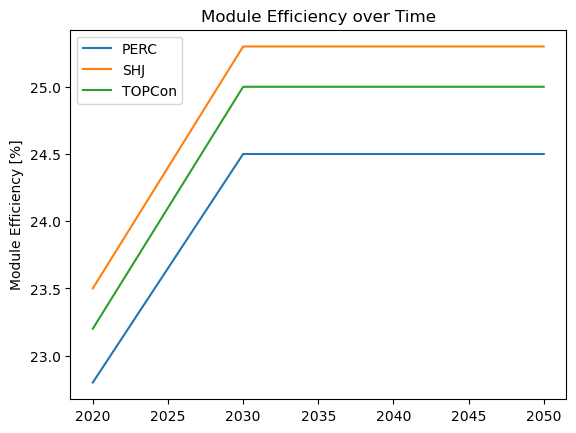

In [13]:
plt.plot(modeffs, label=modeffs.columns)
plt.legend()
plt.title('Module Efficiency over Time')
plt.ylabel('Module Efficiency [%]')

Text(0, 0.5, 'Silver Intensity [kg/m2]')

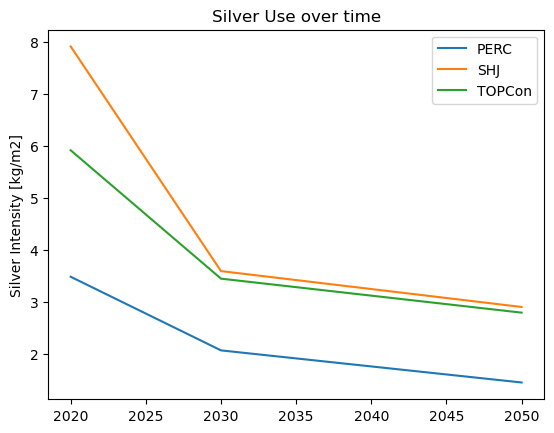

In [14]:
plt.plot(Aguse, label=Aguse.columns)
plt.legend()
plt.title('Silver Use over time')
plt.ylabel('Silver Intensity [kg/m2]')

One important aspect of these technologies is bifaciality. Each has a different bifaciality factor, and they are not expected to increase substantially with time (ITRPV 2022). We plan to explore monofacial and bifacial modules of these technologies (for example residential vs utility). We will use a static inventory of bifacial factors.

In [15]:
bifiFactors = {'PERC':0.7,
              'SHJ':0.9,
              'TOPCon':0.8} # ITRPV 2022, Fig. 58

In [16]:
#PV ICE currently set up to read in a csv of bifi factors, so generate files to read in 
idx_temp = Aguse.index
df_temp = pd.DataFrame(index=idx_temp, columns=['bifi'], dtype=float)
bifi_perc = df_temp.copy()
bifi_perc['bifi'] = bifiFactors['PERC']
bifi_shj = df_temp.copy()
bifi_shj['bifi'] = bifiFactors['SHJ']
bifi_topcon = df_temp.copy()
bifi_topcon['bifi'] = bifiFactors['TOPCon']

In [17]:
bifi_perc.to_csv(path_or_buf=os.path.join(testfolder,'bifi_perc.csv'), index_label='Year')
bifi_shj.to_csv(path_or_buf=os.path.join(testfolder,'bifi_shj.csv'), index_label='Year')
bifi_topcon.to_csv(path_or_buf=os.path.join(testfolder,'bifi_topcon.csv'), index_label='Year')

In [18]:
bifi_perc_path = os.path.join(testfolder,'bifi_perc.csv')
bifi_shj_path = os.path.join(testfolder,'bifi_shj.csv')
bifi_topcon_path = os.path.join(testfolder,'bifi_topcon.csv')

To create a blended scenario, we will use the ITRPV 2022 cell market share projection through 2030, and then keep it constant through 2050.

In [19]:
#insert data from Jarett here
itrpv_celltech_marketshare = pd.read_csv(os.path.join(supportMatfolder,'CellTechCompare','ITRPV_celltech_marketshare.csv'), index_col=0)

In [20]:
itrpv_celltech_marketshare.columns
#there are more cell techs here than I need - I'm not currently concerned with n-type vs p-type
#the marketshares of "n-type back contact", "n-type other", "tandem si-based" are small and outside scope of study
#remove and renormalize.

Index(['p-type (Al-BSF)', 'p-type (PERC)', 'p-type (TOPCon)',
       'n-type (back contact)', 'n-type (SHJ)', 'n-type (TOPCon)',
       'n-type (other)', 'tandem (Si-based)'],
      dtype='object')

In [21]:
#subset for desired techs
celltech_marketshare_sub_raw = itrpv_celltech_marketshare.loc[2020:].filter(regex=('PERC|TOPCon|SHJ')) 
#interpolate to fill gaps
celltech_marketshare_sub_raw.interpolate(inplace=True, limit_direction='both')
#renormalize
celltech_marketshare_sub_raw['temp_sum'] = celltech_marketshare_sub_raw.iloc[:,[0,1,2,3]].sum(axis=1)
celltech_marketshare_sub_raw['scale'] = 1/celltech_marketshare_sub_raw['temp_sum'] #create scaling factor
celltech_marketshare_scaled = celltech_marketshare_sub_raw.iloc[:,[0,1,2,3]]*celltech_marketshare_sub_raw.loc[:,['scale']].values
#celltech_marketshare_scaled.sum(axis=1) # test check that everything adds to 1

In [22]:
celltech_marketshare_scaled.columns

Index(['p-type (PERC)', 'p-type (TOPCon)', 'n-type (SHJ)', 'n-type (TOPCon)'], dtype='object')

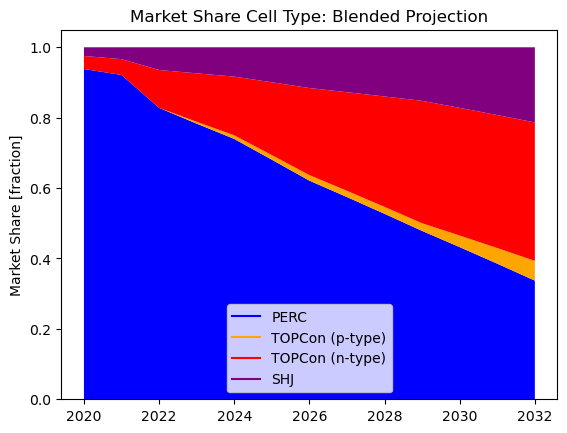

In [23]:
plt.plot([],[],color='blue', label='PERC')
plt.plot([],[],color='orange', label='TOPCon (p-type)')
plt.plot([],[],color='red', label='TOPCon (n-type)')
plt.plot([],[],color='purple', label='SHJ')
#plt.plot([],[],color='red', label='Cell')

plt.stackplot(celltech_marketshare_scaled.index,
              celltech_marketshare_scaled['p-type (PERC)'],
              celltech_marketshare_scaled['p-type (TOPCon)'],
              celltech_marketshare_scaled['n-type (TOPCon)'],
              celltech_marketshare_scaled['n-type (SHJ)'],
              colors = ['blue','orange','red','purple'])

plt.title('Market Share Cell Type: Blended Projection')
plt.ylabel('Market Share [fraction]')
#plt.xlim(1995,2022)
plt.legend(loc='lower center')
plt.show()

In [24]:
celltech_marketshare_scaled['TOPCon'] = celltech_marketshare_scaled.filter(like='TOPCon').sum(axis=1)

Other Assumptions:
- silicon wafer thickness is identical, and improvements are identical
- glass-glass module package for bifacial using 2.5mm glass for both
- module manufacturing energy is identical (until we get better data)
- degradation rates between the technologies are identical (until we get better data)
- Weibull Failure probabilities are identical between technologies (until we get better data)
- No ciruclarity

In [25]:
#glass-glass package mass per area calculation
#ITRPV 2022 Figs 36 and 38, we are assuming that the front and back glass heave equal thickness of 2.5mm
density_glass = 2500*1000 # g/m^3 
glassperm2 = (2.5/1000)* 2 * density_glass
print('The mass per module area of glass is '+str(glassperm2)+' g/m^2')

The mass per module area of glass is 12500.0 g/m^2


Pull in deployment projection. This deployment is based on the Solar Futures report, but has been modified to be more reasonable annual deployment schedule (i.e. manufacturing ramps up). However, this does not achieve 95% RE by 2035, but it does achieve 100% RE in 2050.

In [26]:
sf_reeds_alts = pd.read_excel(os.path.join(supportMatfolder,'SF_reeds_alternates.xlsx'),index_col=0)

In [27]:
sf_reeds = sf_reeds_alts.loc[2023:2050,['MW']]

In [28]:
#try sorting the Reeds Deployment to be in ascending order
sf_reeds['MW'].values.sort() #this sorts the column values in place

In [29]:
sf_reeds['TW_cum'] = sf_reeds['MW'].cumsum()/1e6

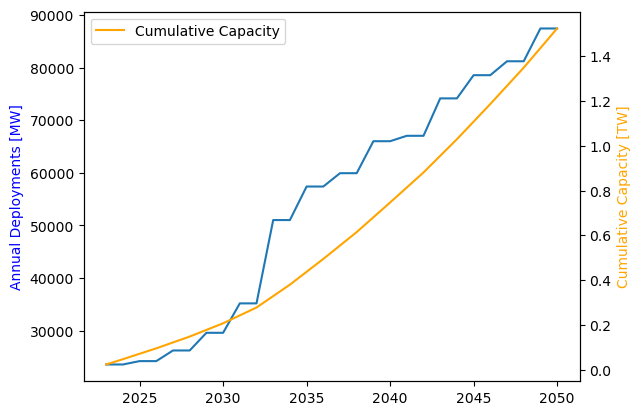

In [30]:
fig, ax1 = plt.subplots()

ax1.plot(sf_reeds['MW'])
ax1.set_ylabel('Annual Deployments [MW]', color='blue')

ax2 = ax1.twinx()
ax2.plot(sf_reeds['TW_cum'], color='orange')
ax2.set_ylabel('Cumulative Capacity [TW]', color='orange')

plt.legend(['Cumulative Capacity'])
plt.show()

In [31]:
sf_reeds.loc[2030]

MW        29613.993350
TW_cum        0.207411
Name: 2030.0, dtype: float64

In [32]:
sf_reeds.loc[2050]

MW        87426.894740
TW_cum        1.523311
Name: 2050.0, dtype: float64

In [33]:
#historical 2020-2022 from Wood Mac
history = sf_reeds_alts.loc[2020:2022,['Historically annual']]
history.columns=['MW']
projection = sf_reeds[['MW']]
newdeploymentcurve = pd.concat([history,projection],axis=0)

# Scenario Creation

In [34]:
#creating scenarios for identical power and identical area deployed
scennames = ['PERC_p','SHJ_p','TOPCon_p', 'PERC_a','SHJ_a','TOPCon_a'] #add later Blend and bifi on/off
MATERIALS = ['glass','silver','silicon'] #, 'copper', 'encapsulant', 'backsheet', 'aluminum_frames'
moduleFile_m = os.path.join(baselinesfolder, 'baseline_modules_mass_US.csv')
moduleFile_e = os.path.join(baselinesfolder, 'baseline_modules_energy.csv')

In [35]:
#load in a baseline and materials for modification
import PV_ICE

sim1 = PV_ICE.Simulation(name='sim1', path=testfolder)
for scen in scennames:
    sim1.createScenario(name=scen, massmodulefile=moduleFile_m, energymodulefile=moduleFile_e)
    for mat in range (0, len(MATERIALS)):
        matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+MATERIALS[mat]+'.csv')
        matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+MATERIALS[mat]+'.csv')
        sim1.scenario[scen].addMaterial(MATERIALS[mat], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

path = C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\TEMP\CellTechCompare


Modify the all one tech scenarios Scenarios:

Module level
- trim to 2020-2050
- no circularity
- deployment projection
- module eff

material level
- glass per m2
- silver per m2

In [36]:
#trim to 2020-2050, this trims module and materials
sim1.trim_Years(startYear=2020)

endYear not provided. Setting to end year of Module data 2050


In [37]:
#no circularity
sim1.scenMod_noCircularity()

In [38]:
#deployment projection
#NEED TO PULL IN DEPLOYMENT PROJECTION

for scen in scennames:
    sim1.scenario[scen].dataIn_m.loc[0:len(newdeploymentcurve.index-1),'new_Installed_Capacity_[MW]'] = newdeploymentcurve.values

In [39]:
#module eff
#modeffs
for scen in scennames:
    sim1.scenario[scen].dataIn_m.loc[0:len(modeffs.index-1),'mod_eff'] = modeffs.filter(like=str(scen[0:3])).values

In [40]:
#glass modify
for scen in scennames:
    sim1.scenario[scen].material['glass'].matdataIn_m['mat_massperm2'] = glassperm2

In [41]:
#silver modify
#Aguse
for scen in scennames:
    sim1.scenario[scen].material['silver'].matdataIn_m.loc[0:len(Aguse.index-1),'mat_massperm2'] = Aguse.filter(like=str(scen[0:3])).values

Check to make sure the modifications took.

In [125]:
sim1.scenario['SHJ_a'].dataIn_m.head(10)

,year,new_Installed_Capacity_[MW],mod_eff,mod_reliability_t50,mod_reliability_t90,mod_degradation,mod_lifetime,mod_MFG_eff,mod_Repair,mod_MerchantTail,...,mod_EOL_pg2_stored,mod_EOL_pg3_reMFG,mod_EOL_pg4_recycled,mod_EOL_reMFG_yield,mod_EOL_sp_reMFG_recycle,mod_EOL_pb1_landfill,mod_EOL_pb2_stored,mod_EOL_pb3_reMFG,mod_EOL_pb4_recycled,mod_EOL_collection_eff
0,2020,19914.550101,23.50,33.0,38.0,0.5,35.0,98.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
1,2021,24094.804465,23.68,33.0,38.0,0.5,35.0,98.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
2,2022,21893.147053,23.86,33.0,38.0,0.5,35.0,98.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
3,2023,23596.728960,24.04,33.0,38.0,0.5,35.0,98.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
4,2024,23596.728960,24.22,33.0,38.0,0.5,35.0,98.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
5,2025,24236.415970,24.40,33.0,38.0,0.5,35.0,98.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
6,2026,24236.415970,24.58,33.0,38.0,0.5,35.0,98.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
7,2027,26258.301320,24.76,40.0,44.0,0.5,35.0,98.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
8,2028,26258.301320,24.94,40.0,44.0,0.5,35.0,98.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
9,2029,29613.993350,25.12,40.0,44.0,0.5,35.0,98.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0


In [43]:
sim1.scenario['SHJ_p'].material['silver'].matdataIn_m.head()

,year,mat_virgin_eff,mat_massperm2,mat_MFG_eff,mat_MFG_scrap_Recycled,mat_MFG_scrap_Recycling_eff,mat_MFG_scrap_Recycled_into_HQ,mat_MFG_scrap_Recycled_into_HQ_Reused4MFG,mat_PG3_ReMFG_target,mat_ReMFG_yield,mat_PG4_Recycling_target,mat_Recycling_yield,mat_EOL_Recycled_into_HQ,mat_EOL_RecycledHQ_Reused4MFG
0,2020,75.0,7.911163,80.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,75.0,7.479315,80.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022,75.0,7.047467,80.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2023,75.0,6.615619,80.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2024,75.0,6.183771,80.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Run Simulations

## Option 1: Compare with Idential Power Installed

In [44]:
scennames_p = ['PERC_p','SHJ_p','TOPCon_p']
bifipaths = [bifi_perc_path,bifi_shj_path,bifi_topcon_path]

In [45]:
#option 1, install identical power
sim1.calculateFlows(scenarios='PERC_p', bifacialityfactors=bifi_perc_path)
sim1.calculateFlows(scenarios='SHJ_p', bifacialityfactors=bifi_shj_path)
sim1.calculateFlows(scenarios='TOPCon_p', bifacialityfactors=bifi_topcon_path)

perc_p_yearly, perc_p_cum = sim1.aggregateResults(scenarios='PERC_p')
shj_p_yearly, shj_p_cum = sim1.aggregateResults(scenarios='SHJ_p')
topcon_p_yearly, topcon_p_cum = sim1.aggregateResults(scenarios='TOPCon_p')

>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_p
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_p
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ_p
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ_p
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
>>>> Calculating Material Flows <<<<

Working on Scenario:  TOPCon_p
*******************

## Option 2: Compare with Idential Area Installed

In [46]:
scennames_a = ['PERC_a','SHJ_a','TOPCon_a']
bifipaths = [bifi_perc_path,bifi_shj_path,bifi_topcon_path]

In [47]:
#Calculate Area deployed based on PERC and modified SF projection above
idx_temp = Aguse.index #grab matching index
area_deploy = pd.DataFrame(index=idx_temp, dtype=float) #create an empty DF
area_deploy['Area'] = sim1.scenario['PERC_p'].dataOut_m['Area'].values
area_deploy.head()

,Area
2020,8.163039e+07
2021,9.803443e+07
2022,8.842215e+07
2023,9.460754e+07
2024,9.392256e+07


In [48]:
#option 1, install identical power
sim1.calculateFlows(scenarios='PERC_a', bifacialityfactors=bifi_perc_path, installByArea=list(area_deploy['Area']))
sim1.calculateFlows(scenarios='SHJ_a', bifacialityfactors=bifi_shj_path,  installByArea=list(area_deploy['Area']))
sim1.calculateFlows(scenarios='TOPCon_a', bifacialityfactors=bifi_topcon_path,  installByArea=list(area_deploy['Area']))

perc_a_yearly, perc_a_cum = sim1.aggregateResults(scenarios='PERC_a')
shj_a_yearly, shj_a_cum = sim1.aggregateResults(scenarios='SHJ_a')
topcon_a_yearly, topcon_a_cum = sim1.aggregateResults(scenarios='TOPCon_a')

>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_a
********************
Calculating installed capacity based on installed Area
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_a
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ_a
********************
Calculating installed capacity based on installed Area
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ_a
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy fo

In [50]:
all_results_yearly, all_results_cum = sim1.aggregateResults()
all_results_yearly.columns

Index(['VirginStock_glass_sim1_PERC_p_[Tonnes]',
       'VirginStock_silver_sim1_PERC_p_[Tonnes]',
       'VirginStock_silicon_sim1_PERC_p_[Tonnes]',
       'VirginStock_Module_sim1_PERC_p_[Tonnes]',
       'WasteAll_glass_sim1_PERC_p_[Tonnes]',
       'WasteAll_silver_sim1_PERC_p_[Tonnes]',
       'WasteAll_silicon_sim1_PERC_p_[Tonnes]',
       'WasteAll_Module_sim1_PERC_p_[Tonnes]',
       'WasteEOL_glass_sim1_PERC_p_[Tonnes]',
       'WasteEOL_silver_sim1_PERC_p_[Tonnes]',
       ...
       'ActiveCapacity_sim1_SHJ_p_[MW]',
       'DecommisionedCapacity_sim1_SHJ_p_[MW]',
       'ActiveCapacity_sim1_TOPCon_p_[MW]',
       'DecommisionedCapacity_sim1_TOPCon_p_[MW]',
       'ActiveCapacity_sim1_PERC_a_[MW]',
       'DecommisionedCapacity_sim1_PERC_a_[MW]',
       'ActiveCapacity_sim1_SHJ_a_[MW]',
       'DecommisionedCapacity_sim1_SHJ_a_[MW]',
       'ActiveCapacity_sim1_TOPCon_a_[MW]',
       'DecommisionedCapacity_sim1_TOPCon_a_[MW]'],
      dtype='object', length=114)

### Compare Effective Capacity

In [133]:
activecapacity_yearly_TW = pd.DataFrame(all_results_yearly.filter(like='ActiveCapacity'))/1e6
activecapacity_yearly_TW_p = activecapacity_yearly_TW.filter(like='_p')
activecapacity_yearly_TW_a = activecapacity_yearly_TW.filter(like='_a')


Text(0, 0.5, 'Effective Capacity [TW]')

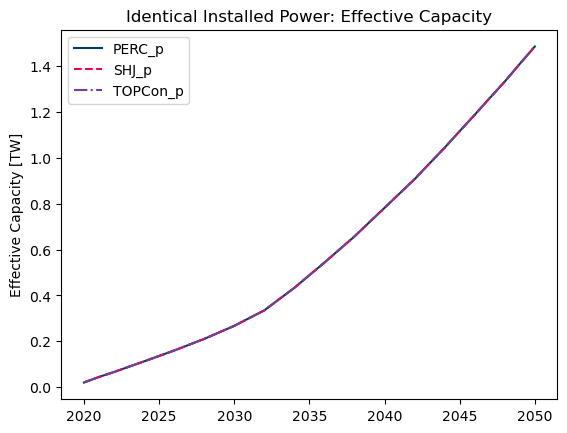

In [161]:
plt.plot(activecapacity_yearly_TW_p.index, activecapacity_yearly_TW_p.iloc[:,[0]], color='#003f5c')
plt.plot(activecapacity_yearly_TW_p.index, activecapacity_yearly_TW_p.iloc[:,[1]], color='#ee005b', ls='--')
plt.plot(activecapacity_yearly_TW_p.index, activecapacity_yearly_TW_p.iloc[:,[2]], color='#734296', ls='-.')
plt.legend(scennames_p)
plt.title('Identical Installed Power: Effective Capacity')
plt.ylabel('Effective Capacity [TW]')

Text(0, 0.5, 'Effective Capacity [TW]')

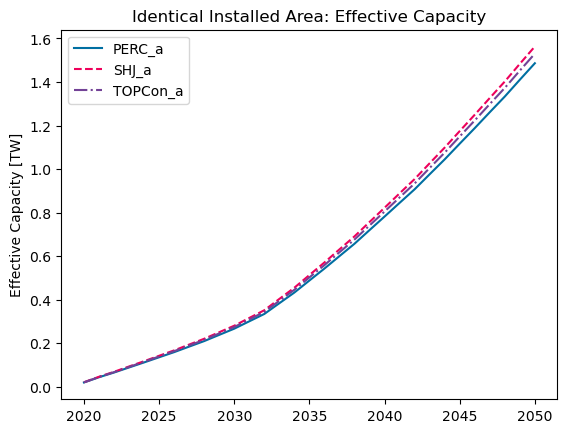

In [160]:
plt.plot(activecapacity_yearly_TW_a.index, activecapacity_yearly_TW_a.iloc[:,[0]], color='#006fa2')
plt.plot(activecapacity_yearly_TW_a.index, activecapacity_yearly_TW_a.iloc[:,[1]], color='#ee005b', ls='--')
plt.plot(activecapacity_yearly_TW_a.index, activecapacity_yearly_TW_a.iloc[:,[2]], color='#734296', ls='-.')
plt.legend(scennames_a)
plt.title('Identical Installed Area: Effective Capacity')
plt.ylabel('Effective Capacity [TW]')

### Compare Area Deployed

In [155]:
#compile all energy out results
area_deployed=pd.DataFrame()
for scen in scennames:
    # add the scen name as a prefix for later filtering
    scen_area = sim1.scenario[scen].dataOut_m[['Cumulative_Active_Area']].add_prefix(str(scen+'_'))
    #concat into one large df
    area_deployed = pd.concat([area_deployed, scen_area], axis=1)

area_deployed.index = idx_temp
area_deployed.tail()

,PERC_p_Cumulative_Active_Area,SHJ_p_Cumulative_Active_Area,TOPCon_p_Cumulative_Active_Area,PERC_a_Cumulative_Active_Area,SHJ_a_Cumulative_Active_Area,TOPCon_a_Cumulative_Active_Area
2046,4.786576e+09,4.551035e+09,4.648721e+09,4.786576e+09,4.786576e+09,4.786576e+09
2047,5.086479e+09,4.836112e+09,4.939884e+09,5.086479e+09,5.086479e+09,5.086479e+09
2048,5.383243e+09,5.118201e+09,5.227991e+09,5.383243e+09,5.383243e+09,5.383243e+09
2049,5.699941e+09,5.419233e+09,5.535445e+09,5.699941e+09,5.699941e+09,5.699941e+09
2050,6.012108e+09,5.715954e+09,5.838492e+09,6.012108e+09,6.012108e+09,6.012108e+09


Text(0, 0.5, 'Area [million m2]')

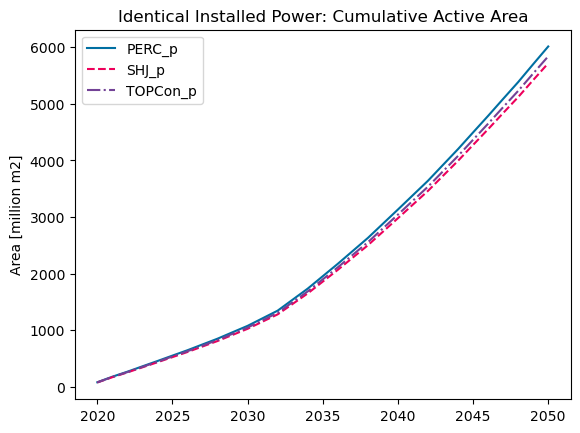

In [162]:
plt.plot(area_deployed.index, area_deployed.iloc[:,[0]]/1e6, color='#006fa2')
plt.plot(area_deployed.index, area_deployed.iloc[:,[1]]/1e6, color='#ee005b', ls='--')
plt.plot(area_deployed.index, area_deployed.iloc[:,[2]]/1e6, color='#734296', ls='-.')
plt.legend(scennames_p)
plt.title('Identical Installed Power: Cumulative Active Area')
plt.ylabel('Area [million m2]')

Text(0, 0.5, 'Area [million m2]')

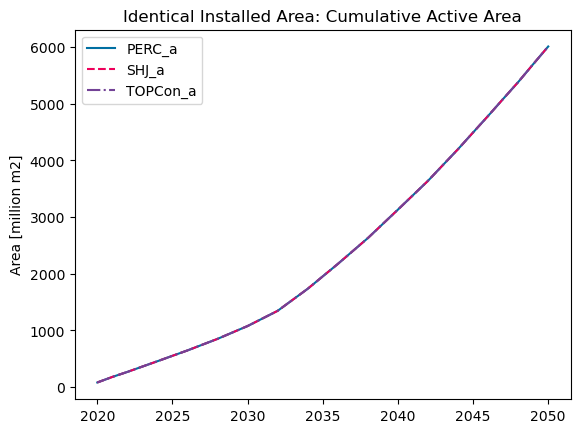

In [163]:
plt.plot(area_deployed.index, area_deployed.iloc[:,[3]]/1e6, color='#006fa2')
plt.plot(area_deployed.index, area_deployed.iloc[:,[4]]/1e6, color='#ee005b', ls='--')
plt.plot(area_deployed.index, area_deployed.iloc[:,[5]]/1e6, color='#734296', ls='-.')
plt.legend(scennames_a)
plt.title('Identical Installed Area: Cumulative Active Area')
plt.ylabel('Area [million m2]')

### Compare Silver Demand

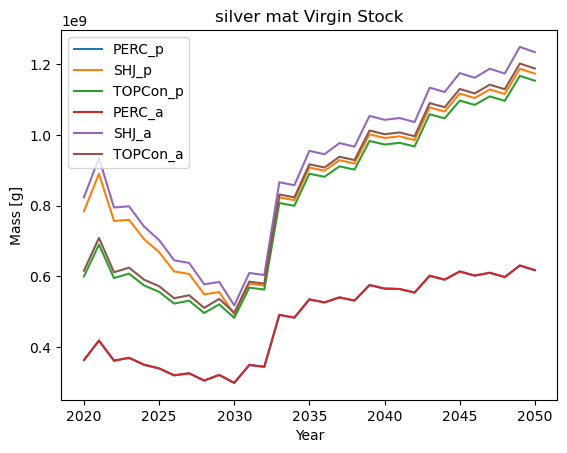

In [49]:
sim1.plotMaterialComparisonAcrossScenarios(keyword='mat_Virgin_Stock', material='silver')

#### Identical Power Deployed

In [51]:
silver_demand_cum = pd.DataFrame(all_results_cum.filter(like='VirginStock_silver').loc[2050]).T

In [165]:
silver_demand_cum
silver_demand_cum.to_csv(os.path.join(testfolder,'Ag_demand_cum2050_allScens.csv'))

Text(0, 0.5, '[Tonnes]')

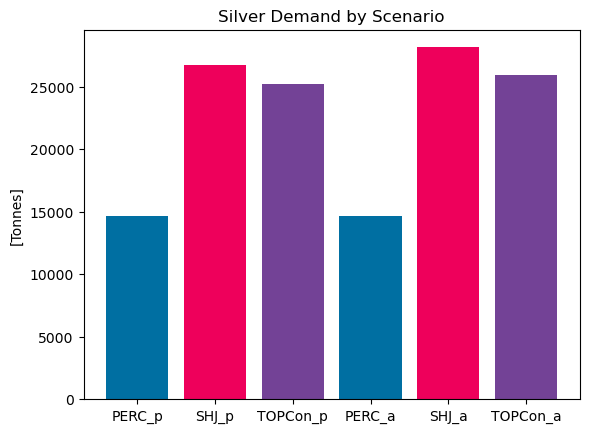

In [164]:
plt.bar(silver_demand_cum.columns, silver_demand_cum.loc[2050], tick_label=(scennames), color=['#006fa2','#ee005b','#734296'])
plt.title('Silver Demand by Scenario')
plt.ylabel('[Tonnes]')


In [120]:
silver_demand_cum

,PERC_p,SHJ_p,TOPCon_p,PERC_a,SHJ_a,TOPCon_a
2050,14688.612491,26780.445286,25218.178097,14688.612491,28163.884796,25964.084502


In [121]:
activecapacity = pd.DataFrame(all_results_yearly.loc[2050].filter(like='ActiveCapacity')).T/1e6
activecapacity

,ActiveCapacity_sim1_PERC_p_[MW],ActiveCapacity_sim1_SHJ_p_[MW],ActiveCapacity_sim1_TOPCon_p_[MW],ActiveCapacity_sim1_PERC_a_[MW],ActiveCapacity_sim1_SHJ_a_[MW],ActiveCapacity_sim1_TOPCon_a_[MW]
2050,1.486283,1.486283,1.486283,1.486283,1.563315,1.530516


In [122]:
silver_demand_cum.columns = activecapacity.columns = scennames

In [123]:
agperW = silver_demand_cum/activecapacity
agperW

,PERC_p,SHJ_p,TOPCon_p,PERC_a,SHJ_a,TOPCon_a
2050,9882.782235,18018.400927,16967.277383,9882.782235,18015.490036,16964.268883


Text(0, 0.5, 'Tonne/TW')

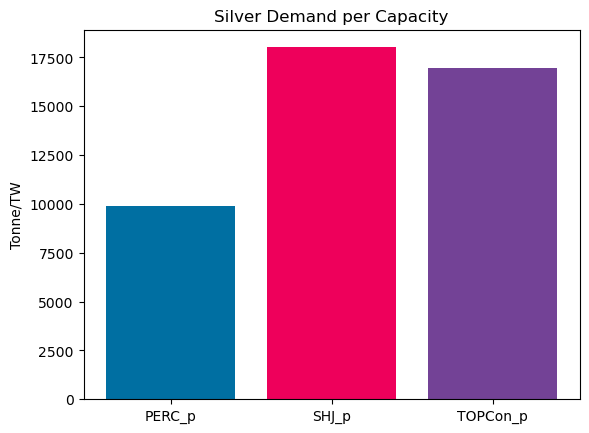

In [173]:
plt.bar(agperW.columns[0:3], agperW.loc[2050][0:3], color=['#006fa2','#ee005b','#734296'])
plt.title('Silver Demand per Capacity')
plt.ylabel('Tonne/TW')

In [54]:
#compile all energy out results
energy_mod=pd.DataFrame()
for scen in scennames:
    # add the scen name as a prefix for later filtering
    scende = sim1.scenario[scen].dataOut_e.loc[0:30].add_prefix(str(scen+'_'))
    #concat into one large df
    energy_mod = pd.concat([energy_mod, scende], axis=1)

energy_mod.tail()

,PERC_p_mod_MFG,PERC_p_mod_Install,PERC_p_mod_OandM,PERC_p_mod_Repair,PERC_p_mod_Demount,PERC_p_mod_Store,PERC_p_mod_Resell_Certify,PERC_p_mod_ReMFG_Disassembly,PERC_p_mod_Recycle_Crush,PERC_p_e_out_annual_[Wh],...,TOPCon_a_mod_MFG,TOPCon_a_mod_Install,TOPCon_a_mod_OandM,TOPCon_a_mod_Repair,TOPCon_a_mod_Demount,TOPCon_a_mod_Store,TOPCon_a_mod_Resell_Certify,TOPCon_a_mod_ReMFG_Disassembly,TOPCon_a_mod_Recycle_Crush,TOPCon_a_e_out_annual_[Wh]
26,1.015141e+12,2.846676e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.893346e+15,...,1.015141e+12,2.846676e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.967769e+15
27,1.049319e+12,2.942517e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.009841e+15,...,1.049319e+12,2.942517e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.088884e+15
28,1.049319e+12,2.942517e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.124680e+15,...,1.049319e+12,2.942517e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.208280e+15
29,1.129815e+12,3.168245e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.247568e+15,...,1.129815e+12,3.168245e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.336047e+15
30,1.129815e+12,3.168245e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.368309e+15,...,1.129815e+12,3.168245e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.461584e+15


In [55]:
energy_mat = pd.DataFrame()
for scen in scennames:
    for mat in MATERIALS:
        # add the scen name as a prefix for later filtering
        scenmatde = sim1.scenario[scen].material[mat].matdataOut_e.loc[0:30].add_prefix(str(scen+'_'+mat+'_'))
        #concat into one large df
        energy_mat = pd.concat([energy_mat, scenmatde], axis=1)

energy_mat.tail()

,PERC_p_glass_mat_extraction,PERC_p_glass_mat_MFG_virgin,PERC_p_glass_mat_MFGScrap_LQ,PERC_p_glass_mat_MFGScrap_HQ,PERC_p_glass_mat_Landfill,PERC_p_glass_mat_EoL_ReMFG_clean,PERC_p_glass_mat_Recycled_LQ,PERC_p_glass_mat_Recycled_HQ,PERC_p_silver_mat_extraction,PERC_p_silver_mat_MFG_virgin,...,TOPCon_a_silver_mat_Recycled_LQ,TOPCon_a_silver_mat_Recycled_HQ,TOPCon_a_silicon_mat_extraction,TOPCon_a_silicon_mat_MFG_virgin,TOPCon_a_silicon_mat_MFGScrap_LQ,TOPCon_a_silicon_mat_MFGScrap_HQ,TOPCon_a_silicon_mat_Landfill,TOPCon_a_silicon_mat_EoL_ReMFG_clean,TOPCon_a_silicon_mat_Recycled_LQ,TOPCon_a_silicon_mat_Recycled_HQ
26,3.989364e+10,1.356148e+13,0.0,0.0,1.859261e+10,0.0,0.0,0.0,1.605243e+07,1.565112e+11,...,0.0,0.0,2.939341e+09,2.428227e+13,0.0,0.0,4.070711e+09,0.0,0.0,0.0
27,4.123676e+10,1.401807e+13,0.0,0.0,2.176776e+10,0.0,0.0,0.0,1.626790e+07,1.586120e+11,...,0.0,0.0,3.038301e+09,2.485281e+13,0.0,0.0,4.285404e+09,0.0,0.0,0.0
28,4.123676e+10,1.401807e+13,0.0,0.0,2.530008e+10,0.0,0.0,0.0,1.594292e+07,1.554435e+11,...,0.0,0.0,3.038301e+09,2.481606e+13,0.0,0.0,4.392868e+09,0.0,0.0,0.0
29,4.440014e+10,1.509343e+13,0.0,0.0,3.042588e+10,0.0,0.0,0.0,1.681604e+07,1.639564e+11,...,0.0,0.0,3.271377e+09,2.676567e+13,0.0,0.0,4.826380e+09,0.0,0.0,0.0
30,4.440014e+10,1.509343e+13,0.0,0.0,3.552260e+10,0.0,0.0,0.0,1.646614e+07,1.605448e+11,...,0.0,0.0,3.271377e+09,2.681157e+13,0.0,0.0,4.980793e+09,0.0,0.0,0.0


In [192]:
allenergy = pd.concat([energy_mod,energy_mat], axis=1)
allenergy.index=idx_temp

In [193]:
energyGen = allenergy.filter(like='e_out_annual')

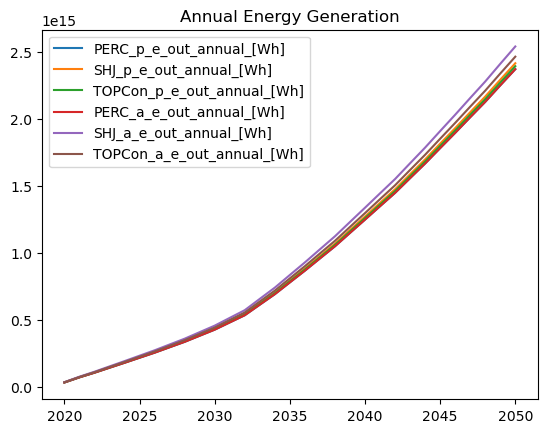

In [194]:
fig, ax1 = plt.subplots()

ax1.plot(energyGen)
#ax1.set_ylabel('Annual Deployments [MW]', color='blue')

#ax2 = ax1.twinx()
#ax2.plot(sf_reeds['TW_cum'], color='orange')
#ax2.set_ylabel('Cumulative Capacity [TW]', color='orange')

plt.legend(energyGen.columns)
plt.title('Annual Energy Generation')
plt.show()

In [195]:
energyGen_p = energyGen.filter(like='_p')/1e12
energyGen_a = energyGen.filter(like='_a')/1e12

Text(0, 0.5, 'Energy Generated [TWh]')

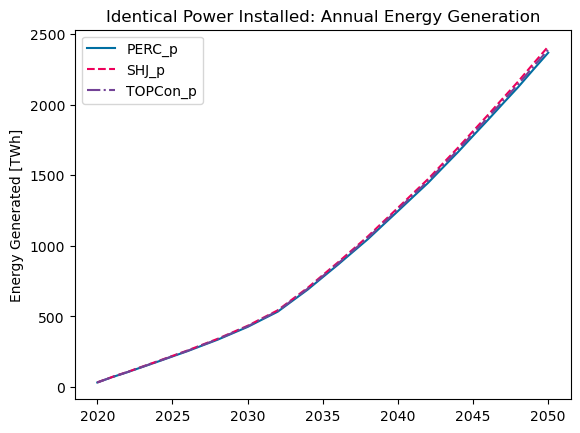

In [196]:
#plt.plot(energyGen_p)#, color=['#006fa2','#ee005b','#734296'])
plt.plot(energyGen_p.index, energyGen_p.iloc[:,[0]], color='#006fa2')
plt.plot(energyGen_p.index, energyGen_p.iloc[:,[1]], color='#ee005b', ls='--')
plt.plot(energyGen_p.index, energyGen_p.iloc[:,[2]], color='#734296', ls='-.')
plt.legend(scennames_p)
plt.title('Identical Power Installed: Annual Energy Generation')
plt.ylabel('Energy Generated [TWh]')

Text(0, 0.5, 'Energy Generated [TWh]')

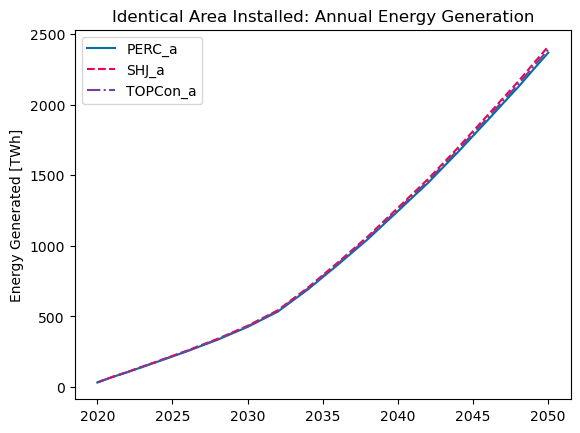

In [198]:
#plt.plot(energyGen_p)#, color=['#006fa2','#ee005b','#734296'])
plt.plot(energyGen_a.index, energyGen_a.iloc[:,[0]], color='#006fa2')
plt.plot(energyGen_a.index, energyGen_a.iloc[:,[1]], color='#ee005b', ls='--')
plt.plot(energyGen_a.index, energyGen_a.iloc[:,[2]], color='#734296', ls='-.')
plt.legend(scennames_a)
plt.title('Identical Area Installed: Annual Energy Generation')
plt.ylabel('Energy Generated [TWh]')

In [59]:
energyGen_cum = energyGen.cumsum()
energyGen_cum_2050 = energyGen_cum.loc[[2050]]

Text(0, 0.5, '[TWh]')

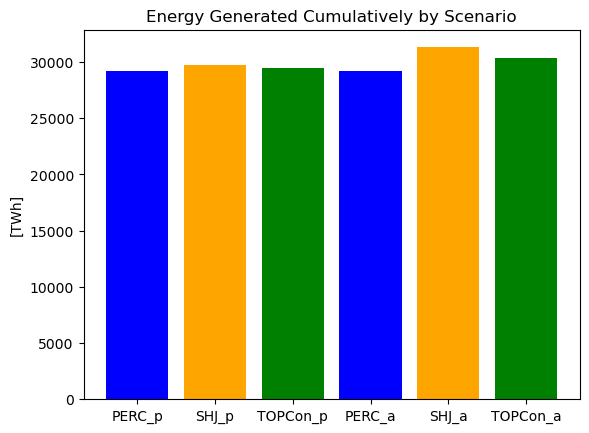

In [65]:
plt.bar(energyGen_cum_2050.columns, energyGen_cum_2050.loc[2050]/1e12, tick_label=(scennames), color=['blue','orange','green'])
plt.title('Energy Generated Cumulatively by Scenario')
plt.ylabel('[TWh]')

In [81]:
energyGen_cum_2050.columns=silver_demand_cum.columns=scennames
whpag = (energyGen_cum_2050)/silver_demand_cum #Wh generated cumulative, per silver demand
normalizer = whpag.loc[2050,'PERC_a']
whpag#/normalizer

,PERC_p,SHJ_p,TOPCon_p,PERC_a,SHJ_a,TOPCon_a
2050,1.989400e+12,1.111547e+12,1.169578e+12,1.989400e+12,1.111494e+12,1.169422e+12


Text(0, 0.5, '[TWh/tonnes]')

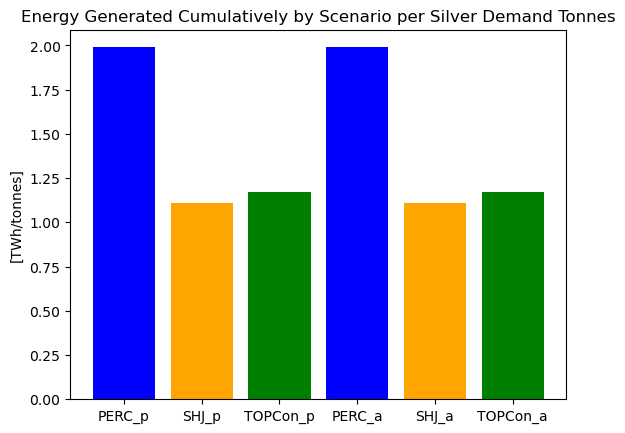

In [82]:
plt.bar(whpag.columns, whpag.loc[2050]/1e12, tick_label=(scennames), color=['blue','orange','green'])
plt.title('Energy Generated Cumulatively by Scenario per Silver Demand Tonnes')
plt.ylabel('[TWh/tonnes]')

In [89]:
energyGen_cum_2050.columns=silver_demand_cum.columns=scennames
agpwh= silver_demand_cum/(energyGen_cum_2050) #Wh generated cumulative, per silver demand
normalizer = agpwh.loc[2050,'PERC_a']
agpwh/normalizer

,PERC_p,SHJ_p,TOPCon_p,PERC_a,SHJ_a,TOPCon_a
2050,1.0,1.789758,1.700956,1.0,1.789843,1.701183


Text(0, 0.5, '[tonnes/TWh] Normalized')

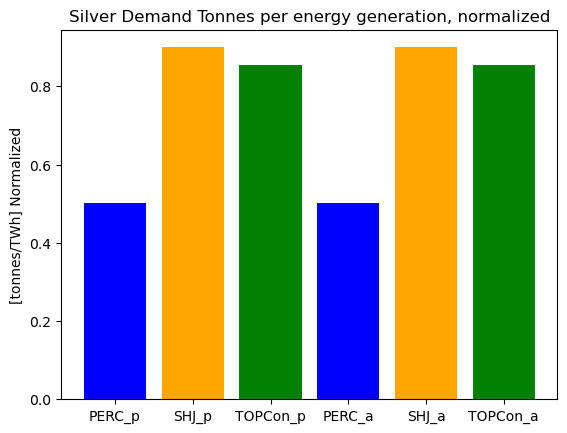

In [92]:
plt.bar(agpwh.columns, agpwh.loc[2050]*1e12, tick_label=(scennames), color=['blue','orange','green'])
plt.title('Silver Demand Tonnes per energy generation, normalized')
plt.ylabel('[tonnes/TWh] Normalized')

In [ ]:
#net energy
allenergy


In [86]:
type(energy_demands)

list

In [84]:
energyGen.filter(like=energy_demands)

TypeError: 'in <string>' requires string as left operand, not list

In [83]:
#categorize the energy in values into lifecycle stages
mfg_energies = ['mod_MFG','mat_extraction','mat_MFG_virgin']
mfg_recycle_energies_LQ = ['mat_MFGScrap_LQ'] #LQ and HQ are separate becuase LQ is only LQ
mfg_recycle_energies_HQ = ['mat_MFGScrap_HQ'] #and HQ material is E_LQ + E_HQ
use_energies = ['mod_Install','mod_OandM','mod_Repair']
eol_energies = ['mat_Landfill','mod_Demount','mod_Store','mod_Resell_Certify']
eol_remfg_energies = ['mod_ReMFG_Disassmbly','mat_EoL_ReMFG_clean']
eol_recycle_energies_LQ = ['mod_Recycle_Crush','mat_Recycled_LQ']
eol_recycle_energies_HQ = ['mod_Recycle_Crush','mat_Recycled_HQ']

energy_demands = [mfg_energies,mfg_recycle_energies_LQ,mfg_recycle_energies_HQ,use_energies,eol_energies,
                  eol_remfg_energies,eol_recycle_energies_LQ,eol_recycle_energies_HQ]

In [63]:
def aggregateEnergyResults(self, scenarios=None, materials=None):
        if scenarios is None:
        scenarios = list(self.scenario.keys())
    else:
        if isinstance(scenarios, str):
            scenarios = [scenarios]

    if materials is None:
        materials = list(self.scenario[scenarios[0]].material.keys())
    else:
        if isinstance(materials, str):
            materials = [materials]
    #categorize the energy in values into lifecycle stages
    mfg_energies = ['mod_MFG','mat_extraction','mat_MFG_virgin']
    mfg_recycle_energies_LQ = ['mat_MFGScrap_LQ'] #LQ and HQ are separate becuase LQ is only LQ
    mfg_recycle_energies_HQ = ['mat_MFGScrap_HQ'] #and HQ material is E_LQ + E_HQ
    use_energies = ['mod_Install','mod_OandM','mod_Repair']
    eol_energies = ['mat_Landfill','mod_Demount','mod_Store','mod_Resell_Certify']
    eol_remfg_energies = ['mod_ReMFG_Disassmbly','mat_EoL_ReMFG_clean']
    eol_recycle_energies_LQ = ['mod_Recycle_Crush','mat_Recycled_LQ']
    eol_recycle_energies_HQ = ['mod_Recycle_Crush','mat_Recycled_HQ']
    
    

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 4)

In [ ]:
#categorize the energy in values into lifecycle stages
mfg_energies = ['mod_MFG','mat_extraction','mat_MFG_virgin']
mfg_recycle_energies_LQ = ['mat_MFGScrap_LQ'] #LQ and HQ are separate becuase LQ is only LQ
mfg_recycle_energies_HQ = ['mat_MFGScrap_HQ'] #and HQ material is E_LQ + E_HQ
use_energies = ['mod_Install','mod_OandM','mod_Repair']
eol_energies = ['mat_Landfill','mod_Demount','mod_Store','mod_Resell_Certify']
eol_remfg_energies = ['mod_ReMFG_Disassmbly','mat_EoL_ReMFG_clean']
eol_recycle_energies_LQ = ['mod_Recycle_Crush','mat_Recycled_LQ']
eol_recycle_energies_HQ = ['mod_Recycle_Crush','mat_Recycled_HQ']